# Filtered ICA on Peak Patch Fields

In [1]:
# %load_ext autoreload

In [39]:
import importlib as il
import copy

import numpy as np
from numpy.random import randint as nprandint
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 12})

from pathlib import Path # For path manipulations and module loading
import pickle

import scipy as sp
from scipy.signal import windows, get_window
from scipy.signal.windows import general_hamming as hamming

# Independent Component Analysis
# sklearn module contains contains a FastICA capability. We can chose the cost function (measure of non-Gaussianity): 
# cube for kurtosis and logcosh for negentropy approximation.
from sklearn.decomposition import FastICA

# %autoreload 2
import modules.sim_params as sim_params
sim_params = il.reload(sim_params)
import modules.init_fields as init_fields
init_fields = il.reload(init_fields)
import modules.slicer_fields as slicer_fields
from modules.slicer_fields import Slicer1D
from modules.slicer_fields import Slicer2D
slicer_fields = il.reload(slicer_fields)

import modules.fields_gauss as gf

zeta multiplication factor = { (2*\pi*sidelength)/(sidelength_in_mpc) }^3

peak-patch/tools/powerspectrum_create

pkp tables/planck18_intermittent.dat
(1st column -- k; 2nd -- delta_delta power spectrum; 3rd -- zeta transfer func/k^2)
zeta power spectrum = 2nd col / 3rd^2

tables/plot_spectra.py line 142

zeta = zeta(g)

take flat GRF power spectrum, multiply by sqrt[ (2*\pi*N / N_in_Mpc)^3 {power spectra above} ].

will have real-space zeta(x) = zeta_g + fnl*chi^2



New runs: /mnt/scratch-lustre/njcarlson/peak-patch-runs/ng7_test_oct6
                Then there’s 3D fields in the “fields" subdirectory, and there’s 2D healpix maps in the “maps" subdirectory, you can play with those with python using healpy.

/mnt/scratch-lustre/njcarlson/peak-patch-runs/s4k_n236_nb20_nt10_ng6_nside2048

In [3]:
# # d_filename='Fvec_fNL_17Mpc_n1024_nb64_nt1'
# # dg_filename='Fvec_17Mpc_n1024_nb64_nt1'
# # z_filename='zetang_17Mpc_n1024_nb64_nt1'
# # zg_filename='zetag_17Mpc_n1024_nb64_nt1'
# # filenames=[d_filename,dg_filename,z_filename, zg_filename]

# # d_filename = 'Fvec_128Mpc_n128_nb40_nt1'
# # dg_filename = 'rhog_128Mpc_n128_nb40_nt1'
# # z_filename = 'zetang_128Mpc_n128_nb40_nt1'
# # zg_filename = 'zetag_128Mpc_n128_nb40_nt1'
# # filenames = [d_filename, dg_filename, z_filename, zg_filename]
# # fields_path = '/mnt/scratch-lustre/njcarlson/peak-patch-runs/ng7_test_oct6/fields'
# # l_buff = 40
# # l_array = 128

# # d_filename = 'Fvec_4000Mpc_n236_nb20_nt10'
# # dg_filename = 'rhog_4000Mpc_n236_nb20_nt10'
# z_filename = 'zetang_4000Mpc_n236_nb20_nt10'
# zg_filename = 'zetag_4000Mpc_n236_nb20_nt10'
# # filenames = [d_filename, dg_filename, z_filename, zg_filename]
# fields_path = '/mnt/scratch-lustre/njcarlson/peak-patch-runs/s4k_n236_nb20_nt10_ng6_nside2048/fnl5e3/fields/'
# l_mpc = 4000
# l_buff = 0
# l_array = 2000
# lengths = [l_mpc, l_buff, l_array]

In [4]:
# # Total nonG zeta field

# # z = init_fields.get_zeta(z_filename)
# zeta_file = fields_path = '/mnt/scratch-lustre/njcarlson/peak-patch-runs/s4k_n236_nb20_nt10_ng6_nside2048/fnl5e3/fields/zetang_4000Mpc_n236_nb20_nt10'
# in_zeta   = open(zeta_file, 'rb')
# # Read in zeta, reshape it into an nxnxn, and then trim off the buffers
# zeta = np.fromfile(in_zeta,dtype=np.float32,count=-1)
# print(zeta.shape)

# # Gaussian zeta field

# # zg = init_fields.get_zeta_g(zg_filename)
# zeta_g_file = '/mnt/scratch-lustre/njcarlson/peak-patch-runs/s4k_n236_nb20_nt10_ng6_nside2048/fnl5e3/fields/zetag_4000Mpc_n236_nb20_nt10'
# in_zeta_g   = open(zeta_g_file, 'rb')
# # Read in zeta_g, reshape it into an nxnxn, and then trim off buffers
# zeta_g = np.fromfile(in_zeta_g,dtype=np.float32,count=-1)
# print(zeta_g.shape)

In [5]:
# print(zeta.shape)
# print(zeta_g.shape)

# z = np.reshape(zeta, (l_array,l_array,l_array), order='F')
# print(z.shape)
# if l_buff != 0:
#     z = z[l_buff:-l_buff,l_buff:-l_buff,l_buff:-l_buff]
# print(z.shape)

# zg = np.reshape(zeta_g, (l_array,l_array,l_array), order='F')
# if l_buff != 0:
#     zg = zg[l_buff:-l_buff,l_buff:-l_buff,l_buff:-l_buff]
# print(zg.shape)


# indices = (nprandint(0, l_array), slice(0, l_array), slice(0, l_array))
# z2d = z[indices]
# print("2d", z2d.shape)
# zg2d = zg[indices]
# print("2dg", zg2d.shape)


# # print(zeta)

## Import 2D field slices from PkP

In [6]:
path_realization = '/mnt/scratch-lustre/njcarlson/peak-patch-runs/ng7_test_oct6/'
path_realization = Path('/mnt/scratch-lustre/njcarlson/peak-patch-runs/s4k_n236_nb20_nt10_ng6_nside2048/fnl5e3/')
seed = 30

l_mpc = 4000
l_array = 2000
l_buff = 0
lengths = [l_mpc, l_array, l_buff]
slicer = Slicer2D(seed, path_realization, lengths)

4000 2000 0 2000
False
False

Processing Zeta fields/components...

zetang_4000Mpc_n236_nb20_nt10
zetag_4000Mpc_n236_nb20_nt10

Getting zeta total...

/mnt/scratch-lustre/njcarlson/peak-patch-runs/s4k_n236_nb20_nt10_ng6_nside2048/fnl5e3/fields/zetang_4000Mpc_n236_nb20_nt10
Zeta total shape: (2000, 2000, 2000)

Getting zeta Gauss...

Zeta Gauss shape: (2000, 2000, 2000)

Getting zeta nonG...

Zeta nonG shape: (2000, 2000, 2000)

Done processing Zeta fields/components!


Checking random entries from each of the fields...


Zeta Gauss-comp (1603, 861, 459):        -0.0014350606
Zeta nonG-comp (1603, 861, 459):          -0.0012347383
Zeta total (1603, 861, 459):              -0.002669799


In [7]:
crnt_seed = np.random.get_state()
np.random.set_state(crnt_seed)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


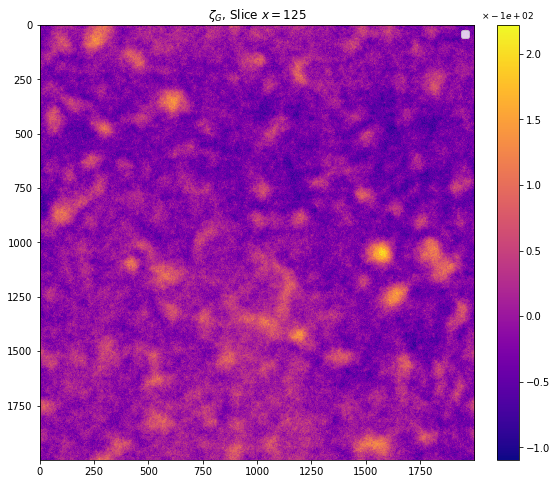

In [28]:
slicer.set_seed(crnt_seed)


fields = slicer.slice_2d(False)
# d_2d, dg_2d, dng_2d, z_2d, zg_2d, zng_2d = fields
z_2d, zg_2d, zng_2d = fields
size = slicer.side_length
idx = slicer.indices

# print(idx)
# print(z_2d)

zfactor = int(1e2)
z_2d = zfactor * z_2d
zgfactor = int(1e2)
zg_2d = zgfactor * zg_2d
zngfactor = int(1e2)
zng_2d = zngfactor * zng_2d
factor = zngfactor

with open(f'data/np-random_states/state_x{idx[0]}.pickle', 'wb') as f:
    pickle.dump(crnt_seed, f)

# with open('crnt_seed.pickle', 'rb') as f:
#     crnt_seed = pickle.load(f)

#--------------------------------------------------#

### Plot 1D Zeta fields

# plt.plot(d_1d, label='Total Zeta')
# plt.plot(dg_2d, label='Gaussian Comp. of Zeta')
# plt.plot(dng_2d, label='nonG Comp. of Zeta')

plt.figure(figsize=(10, 8))
plt.title(r'$\zeta_G$, Slice $x = {x}$'.format(x=idx[0]))
# plt.imshow(z_2d, interpolation='none', cmap='plasma', vmin=-4.5, vmax=4.5)
plt.imshow(z_2d, interpolation='none', cmap='plasma')
plt.colorbar(fraction=0.046, pad=0.04).ax.set_title(rf'$\times {-factor:.0e}$', fontsize=9)
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.legend()
plt.show()

In [40]:

print(np.random.random((2,5)))

[[4.56355538e-01 6.55058798e-01 2.12380196e-02 2.04930744e-01
  9.27685365e-01]
 [1.19245461e-01 6.73523447e-04 4.33454735e-01 7.01761706e-01
  2.68273668e-02]]


In [75]:
nchunks = 6
lchunk = int(slicer.side_length / (nchunks/2))


zchunk1 = z_2d[:lchunk, :lchunk]/zfactor
zchunk2 = z_2d[:lchunk, lchunk:-lchunk]/zfactor
zchunk3 = z_2d[:lchunk, -lchunk:]/zfactor
zchunk4 = z_2d[lchunk:-lchunk, lchunk:]/zfactor
zchunk5 = z_2d[lchunk:-lchunk, :lchunk]/zfactor
zchunk6 = z_2d[lchunk:-lchunk, lchunk:]/zfactor
zchunk6 = z_2d[lchunk:, lchunk:]/zfactor
zngchunk1 = zng_2d[:lchunk, :lchunk]/zngfactor
zngchunk2 = zng_2d[:lchunk, lchunk:]/zngfactor
zngchunk3 = zng_2d[lchunk:, :lchunk]/zngfactor
zngchunk4 = zng_2d[lchunk:, lchunk:]/zngfactor

zchunks = np.array([zchunk1, zchunk2, zchunk3, zchunk4])
print(zchunks.shape)
zchunks = np.reshape(zchunks, (nchunks, -1))
print(zchunks.shape)


np.save("data/2d_zeta_fields/z2dchunk1_statex{idxx}_chi_ng6".format(idxx=idx[0]), zchunk1)
np.save("data/2d_zeta_fields/z2dchunk2_statex{idxx}_chi_ng6".format(idxx=idx[0]), zchunk2)
np.save("data/2d_zeta_fields/z2dchunk3_statex{idxx}_chi_ng6".format(idxx=idx[0]), zchunk3)
np.save("data/2d_zeta_fields/z2dchunk4_statex{idxx}_chi_ng6".format(idxx=idx[0]), zchunk4)

"""
For MATLAB:
"""
zc1 = {'y': zchunk1}
zc2 = {'y': zchunk2}
zc3 = {'y': zchunk3}
zc4 = {'y': zchunk4}
sp.io.savemat("data/2d_zeta_fields/z2dchunk1_statex{idxx}_chi_ng6.mat".format(idxx=idx[0]), zc1)
sp.io.savemat("data/2d_zeta_fields/z2dchunk2_statex{idxx}_chi_ng6.mat".format(idxx=idx[0]), zc2)
sp.io.savemat("data/2d_zeta_fields/z2dchunk3_statex{idxx}_chi_ng6.mat".format(idxx=idx[0]), zc3)
sp.io.savemat("data/2d_zeta_fields/z2dchunk4_statex{idxx}_chi_ng6.mat".format(idxx=idx[0]), zc4)




(4, 1000, 1000)
(4, 1000000)


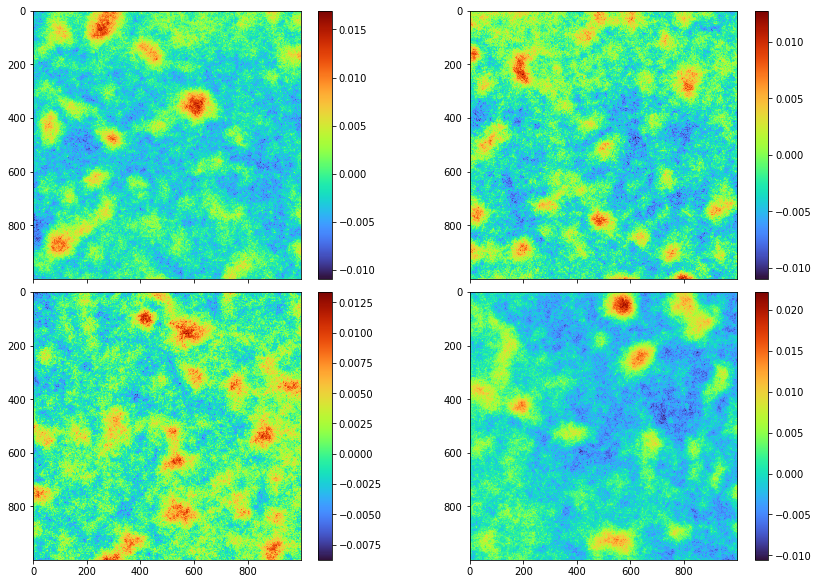

In [76]:

fig, ax = plt.subplots(2, 2, figsize=(6*2, 4*2), sharex='all',constrained_layout=True)


# ax[0,0].title(r'$\zeta_G$, Slice $x = {x}$'.format(x=idx[0]))
im0 = ax[0,0].imshow(zchunk1, interpolation='none', cmap='turbo')
# ax[0,0].colorbar(fraction=0.046, pad=0.04).ax.set_title(rf'$\times {-factor:.0e}$', fontsize=9)
fig.colorbar(im0, ax=ax[0, 0])
# ax[0,0].legend()

im1 = ax[0,1].imshow(zchunk2, interpolation='none', cmap='turbo')
# ax[0,1].colorbar(fraction=0.046, pad=0.04).ax.set_title(rf'$\times {-factor:.0e}$', fontsize=9)
fig.colorbar(im1, ax=ax[0,1])
# ax[0,1].legend()

im2 = ax[1,0].imshow(zchunk3, interpolation='none', cmap='turbo')
# ax[1,0].colorbar(fraction=0.046, pad=0.04).ax.set_title(rf'$\times {-factor:.0e}$', fontsize=9)
fig.colorbar(im2, ax=ax[1, 0])
# ax[1,0].legend()

im3 = ax[1,1].imshow(zchunk4, interpolation='none', cmap='turbo')
# ax[1,1].colorbar(fraction=0.046, pad=0.04).ax.set_title(rf'$\times {-factor:.0e}$', fontsize=9)
fig.colorbar(im3, ax=ax[1, 1])
# ax[1,1].legend()

plt.show()

## <u>Apply Filtered ICA to 2D strips from the 3D fields</u>
<b> For fully determined ICA separation.
<br>
Sklearn's implementation does not allow for underdetermined separation. </b>

### Setup

In [84]:
############################################################
#
# FASTICA
#
############################################################



num_comps=4; 
max_iter = int(5e15)
tol = 1e-14
fun='logcosh'; whiten='unit-variance'; algo='parallel';
"""Initialize FastICA with given params.

Notes:
        Logcosh is negentropy.
"""
    
# , white='unit-variance'
transformer = FastICA(n_components=num_comps, algorithm=algo, whiten=whiten, max_iter=max_iter, tol=tol, fun=fun)

print(zchunks.shape)
# run FastICA on observed (mixed) signals
sources = transformer.fit_transform(zchunks.T)

print(transformer.components_.shape)

sources = sources.T
print(sources.shape)
z_ica = np.reshape(sources, (num_comps, 1000, -1))
z_ica.shape

(4, 1000000)
(4, 4)
(4, 1000000)


(4, 1000, 1000)

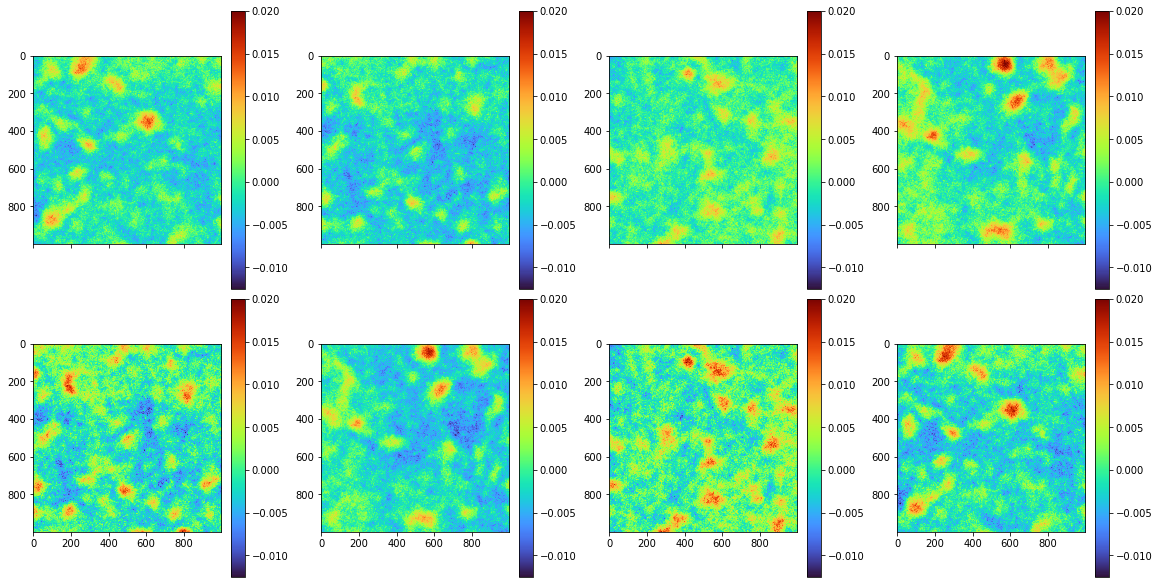

In [88]:
fig, ax = plt.subplots(2, 4, figsize=(8*2, 4*2), sharex='all',constrained_layout=True)

vmin = -0.0125
vmax = 0.020
# ax[0,0].title(r'$\zeta_G$, Slice $x = {x}$'.format(x=idx[0]))
im0 = ax[0,0].imshow(zchunk1, interpolation='none', cmap='turbo', vmin=vmin, vmax=vmax)
# ax[0,0].colorbar(fraction=0.046, pad=0.04).ax.set_title(rf'$\times {-factor:.0e}$', fontsize=9)
fig.colorbar(im0, ax=ax[0, 0])
# ax[0,0].legend()

im1 = ax[0,1].imshow(zchunk2, interpolation='none', cmap='turbo', vmin=vmin, vmax=vmax)
# ax[0,1].colorbar(fraction=0.046, pad=0.04).ax.set_title(rf'$\times {-factor:.0e}$', fontsize=9)
fig.colorbar(im1, ax=ax[0,1])
# ax[0,1].legend()

im2 = ax[0,2].imshow(zchunk3, interpolation='none', cmap='turbo', vmin=vmin, vmax=vmax)
# ax[1,0].colorbar(fraction=0.046, pad=0.04).ax.set_title(rf'$\times {-factor:.0e}$', fontsize=9)
fig.colorbar(im2, ax=ax[0, 2])
# ax[1,0].legend()

im3 = ax[0,3].imshow(zchunk4, interpolation='none', cmap='turbo', vmin=vmin, vmax=vmax)
# ax[1,1].colorbar(fraction=0.046, pad=0.04).ax.set_title(rf'$\times {-factor:.0e}$', fontsize=9)
fig.colorbar(im3, ax=ax[0, 3])
# ax[1,1].legend()

im4 = ax[1,0].imshow(-z_ica[0, ...], interpolation='none', cmap='turbo')
# ax[1,0].colorbar(fraction=0.046, pad=0.04).ax.set_title(rf'$\times {-factor:.0e}$', fontsize=9)
fig.colorbar(im2, ax=ax[1, 0])
# ax[1,0].legend()

im5 = ax[1,1].imshow(z_ica[1, ...], interpolation='none', cmap='turbo')
# ax[1,1].colorbar(fraction=0.046, pad=0.04).ax.set_title(rf'$\times {-factor:.0e}$', fontsize=9)
fig.colorbar(im3, ax=ax[1, 1])
# ax[1,1].legend()

im6 = ax[1,2].imshow(-z_ica[2, ...], interpolation='none', cmap='turbo')
# ax[1,0].colorbar(fraction=0.046, pad=0.04).ax.set_title(rf'$\times {-factor:.0e}$', fontsize=9)
fig.colorbar(im2, ax=ax[1, 2])
# ax[1,0].legend()

im7 = ax[1,3].imshow(-z_ica[3, ...], interpolation='none', cmap='turbo')
# ax[1,1].colorbar(fraction=0.046, pad=0.04).ax.set_title(rf'$\times {-factor:.0e}$', fontsize=9)
fig.colorbar(im3, ax=ax[1, 3])
# ax[1,0].legend()

plt.show()

### Apply Sklearn's $\texttt{FastICA}$

In [ ]:
from math import log10, floor
round_to_n = lambda x, n: round(x, -int(floor(log10(x))) + (n - 1))

dist nong->ica1: 50.82386069846561  | dist nong->ica0: 50.784070152797355
dist g->ica0: 180.57022287066098  | dist g->ica1: 180.5206386917696

Processing k-bin number:    1 ...
dist nong->ica1: 4.897262508897242  | dist nong->ica0: 4.8237829077539605
dist g->ica0: 31.125609128727568  | dist g->ica1: 31.147894165735288

Processing k-bin number:    2 ...
dist nong->ica1: 4.603789849690805  | dist nong->ica0: 4.669128990476273
dist g->ica0: 6.60415630900596  | dist g->ica1: 6.668673789811264
dist nong->ica1: 4.603789849690805  | dist nong->ica0: 4.669128990476273
dist g->ica0: 6.60415630900596  | dist g->ica1: 6.668673789811264
Swapped!

Processing k-bin number:    3 ...
dist nong->ica1: 0.09365013327192864  | dist nong->ica0: 0.09547752013473063
dist g->ica0: 5.225025426253348  | dist g->ica1: 5.167957741501754
dist nong->ica1: 0.09365013327192864  | dist nong->ica0: 0.09547752013473063
dist g->ica0: 5.225025426253348  | dist g->ica1: 5.167957741501754
Swapped!
Gauss sign flipped!
NonG s

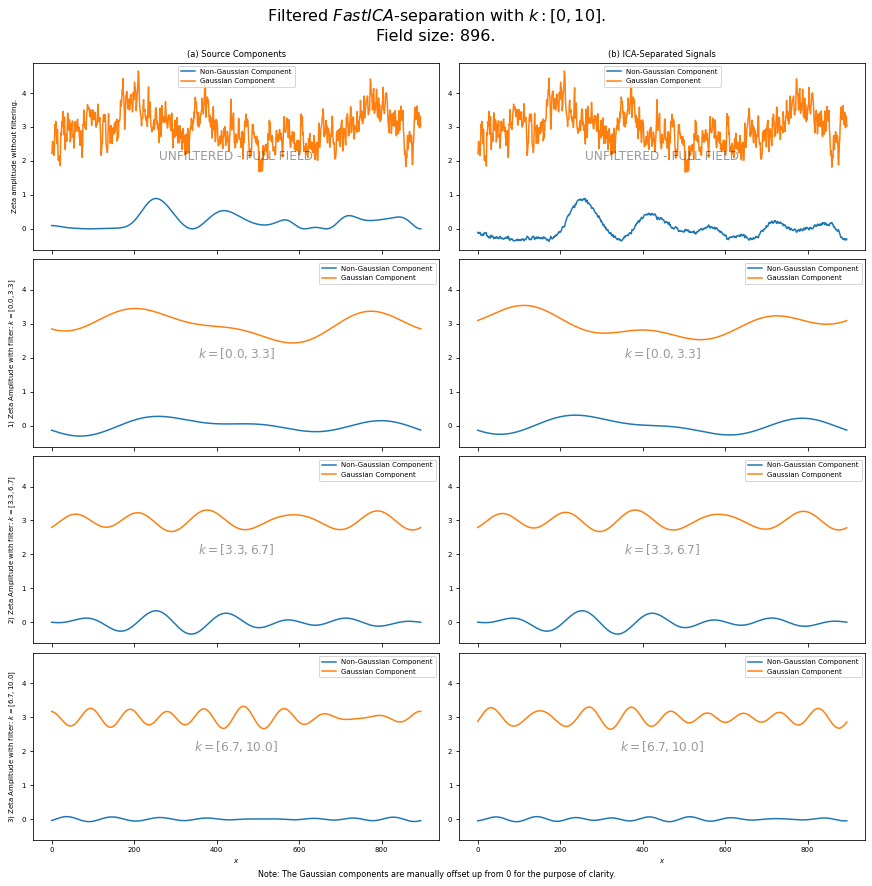

In [ ]:
"""Filtering.

"""

#
#
# Filtering parameters/vars
#
#
nbins = 3
k_size = size//2 + 1
k_low = 0
k_high = 10
kc = np.linspace(0, k_high, nbins+1)
# kc = np.array([0, 20, 40, 80])
kc_size = kc.size

#
#
# ICA parameters/vars
#
#
max_iter = int(9e13)
tol = 1e-12
ica_src = np.zeros((kc_size+1, 2, size))

#
#
# Run ICA
#
#
mix_signal, src, num_comps = ica_setup(zg_1d, zng_1d)
ica_src_og = ica_run(mix_signal, num_comps, max_iter, tol)
ica_src[0, :], src_max, ica_max = ica_prepres(src, ica_src_og)


#
#
# Plot
#
#
plt.rcParams.update({'font.size': 7})
nrows = nbins + 1
ncols = 2

fig, ax = plt.subplots(nrows, ncols, sharex='all', figsize=(6*ncols, 3*nrows), constrained_layout=True)

offset = src_max[0]*1.8
offset_ica = ica_max[0]*1.8

ax00 = ax[0, 0]
# Plotting source components
ax[0, 0].set_title("(a) Source Components")
for j in range(num_comps):
    if j == 0:
        label = "Non-Gaussian Component"
    else:
        label = "Gaussian Component"
    ax[0, 0].plot(src[j, :] + offset*j, label=label)
ax[0, 0].set(ylabel="Zeta amplitude without filtering.")
ax[0, 0].legend()

ax01 = ax[0, 1]
# Plotting ICA-separated signals
ax[0, 1].set_title("(b) ICA-Separated Signals")
ax[0, 1].sharey(ax00)
for j in range(num_comps):
    if j == 0:
        label = "Non-Gaussian Component"
    else:
        label = "Gaussian Component"
    ax[0, 1].plot(ica_src[0, j, :] + offset_ica*j, label=label) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
ax[0, 1].legend()

ax[0, 0].text(0.5, 0.5, "UNFILTERED - FULL FIELD", 
                fontsize='xx-large', transform=ax[0, 0].transAxes, 
                    ha='center', va='center', alpha=0.4)
ax[0, 1].text(0.5, 0.5, "UNFILTERED - FULL FIELD", 
                fontsize='xx-large', transform=ax[0, 1].transAxes, 
                    ha='center', va='center', alpha=0.4)


for i in range(kc_size-1):
    count = i+1
    klow = kc[i]
    khigh = kc[i+1]

    print(f"\nProcessing k-bin number:    {count} ...")

    #
    #
    # Filter
    #
    #
    filtered = filter(zg_1d, zng_1d, size, int(klow), int(khigh))
    zgf, zngf = filtered[0], filtered[1]
    
    #
    #
    # Run ICA
    #
    #
    mix_signal, src, num_comps = ica_setup(zgf, zngf)
    ica_src_og = ica_run(mix_signal, num_comps, max_iter, tol)
    ica_src[count, :], src_max, ica_max = ica_prepres(src, ica_src_og)

    offset_ = src_max[0]*1.8
    offset_ica_ = ica_max[0]*1.8
    klow = round(klow, 1); khigh = round(khigh, 1)

    # Plotting source components
    ax[count, 0].sharey(ax00)
    for j in range(num_comps):
        if j == 0:
            label = "Non-Gaussian Component"
        else:
            label = "Gaussian Component"
        ax[count, 0].plot(src[j, :] + offset*j, label=label)
    ax[count, 0].set(ylabel=f'{i+1}) ' + "Zeta Amplitude with filter: " + r"$k=[{{{kl}}}, {{{kh}}}]$".format(kl=klow, kh=khigh))
    ax[count, 0].legend()
    
    ax[count, 1].sharey(ax00)
    # Plotting ICA-separated signals
    for j in range(num_comps):
        if j == 0:
            label = "Non-Gaussian Component"
        else:
            label = "Gaussian Component"
        ax[count, 1].plot(ica_src[count, j, :] + offset_ica*j, label=label) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
    ax[count, 1].legend()

    ax[count, 0].text(0.5, 0.5, r"$k=[{{{kl}}}, {{{kh}}}]$".format(kl=klow, kh=khigh), 
                            fontsize='xx-large', transform=ax[count, 0].transAxes, 
                                ha='center', va='center', alpha=0.4)
    ax[count, 1].text(0.5, 0.5, r"$k=[{{{kl}}}, {{{kh}}}]$".format(kl=klow, kh=khigh), 
                            fontsize='xx-large', transform=ax[count, 1].transAxes, 
                                ha='center', va='center', alpha=0.4)

ax_count = kc_size-1
ax[ax_count, 0].set(xlabel=r'$x$')
ax[ax_count, 1].set(xlabel=r'$x$')

fig.suptitle(rf'Filtered $\it{{FastICA}}$-separation with $k: [{{{k_low}}}, {{{k_high}}}]$.' + f'\nField size: {size}.', fontsize=16)

note="Note: The Gaussian components are manually offset up from 0 for the purpose of clarity."
fig.text(0.5, -0.01, note, wrap=True, horizontalalignment='center', fontsize=8)
plt.show()

plt.savefig(f'/fs/lustre/cita/haider/projects/primordialNonG_code/ica/plots/icafiltered_pkp_s{size}_{klow}to{khigh}k{nbins}.png')

<Figure size 432x288 with 0 Axes>

### TODO: Rank-order the extracted signals (by a nonG measure)
e.g. using kurtosis

In [ ]:
# # Rank-order by a nonGaussianity measure (kurtosis for simplicity)
# nt = 100; a = np.empty((nt,s.shape[0],s.shape[1])) 
# for i in range(nt):
#     a[i] = ica.extract_peaks_nn(num_samples=num_samples, num_components=num_comps, noise=noise, aPeak=aPeak, xPeak=xPeak, wPeak=wPeak, ns=size_field)[-1]
# kur = ica.kurtosis(a)

# print(kur.shape)
# fig, a = plt.subplots()
# fig.set_size_inches(15, 15)
# for i in range(kur.shape[-1]):
#     a.plot(kur[:,i]+25.*i)